<a href="https://colab.research.google.com/github/wuhyyy/TKAN-AE/blob/main/%E2%80%9C%E2%80%9CInformer_AE_anomaly_detection_ipynb%E2%80%9Dpaper%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Dec 29 11:00:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#!pip install gdown
#!pip install transformers
#!pip install tensorflow-gpu

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
#from transformers import InformerConfig, InformerModel
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
#!gdown --id 1LKuN9oSHNg7jJa9FEv9AhetotoVm2HepN --output run.csv
#https://docs.google.com/spreadsheets/d/1x6yN9jbhFXwZDeaNLyW3pziXrNmRWoZi/edit?usp=drive_link&ouid=115607611299548780466&rtpof=true&sd=true

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PrxHkSQGBKoWJk4ec55gHC9-Mtj6s6ra
To: /content/spx.csv
100% 190k/190k [00:00<00:00, 42.7MB/s]


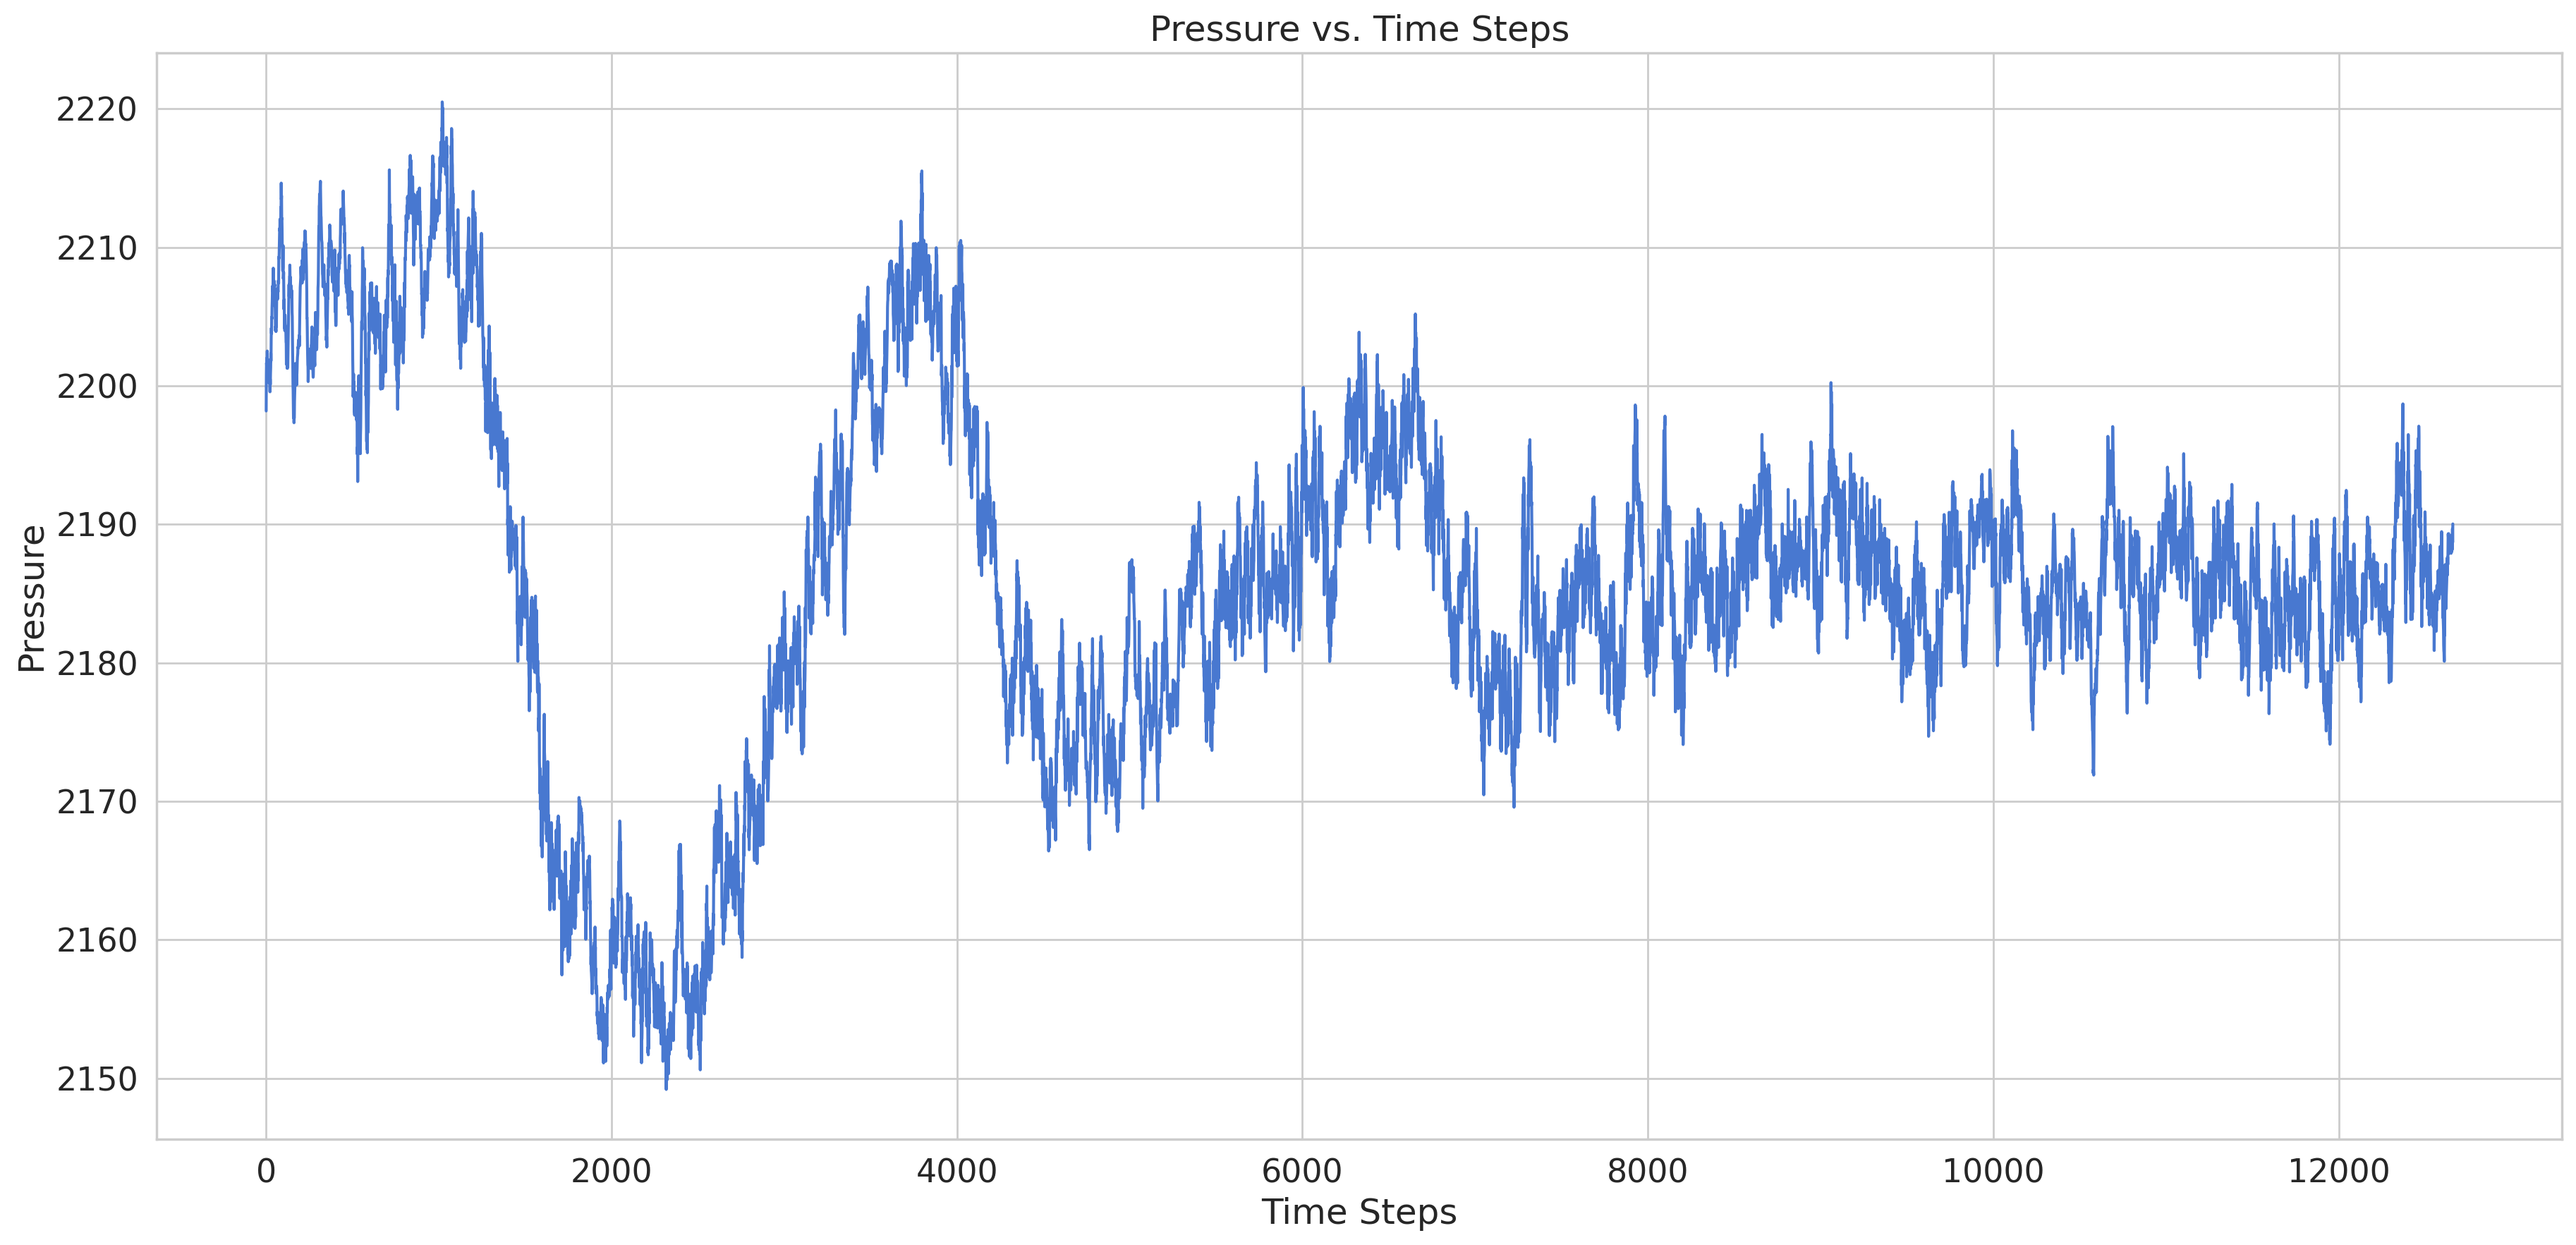

In [5]:
!gdown --id 1PrxHkSQGBKoWJk4ec55gHC9-Mtj6s6ra --output spx.csv
# prompt: 读取spx.csv中的内容，然后绘图，横坐标是time steps，纵坐标是pressure

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('spx.csv')

plt.plot(df['time steps'], df['pressure'])
plt.xlabel('Time Steps')
plt.ylabel('Pressure')
plt.title('Pressure vs. Time Steps')
plt.show()


In [6]:
df.head()

,time steps,pressure
0,1,2198.180
1,2,2200.794
2,3,2201.657
3,4,2201.421
4,5,2202.008


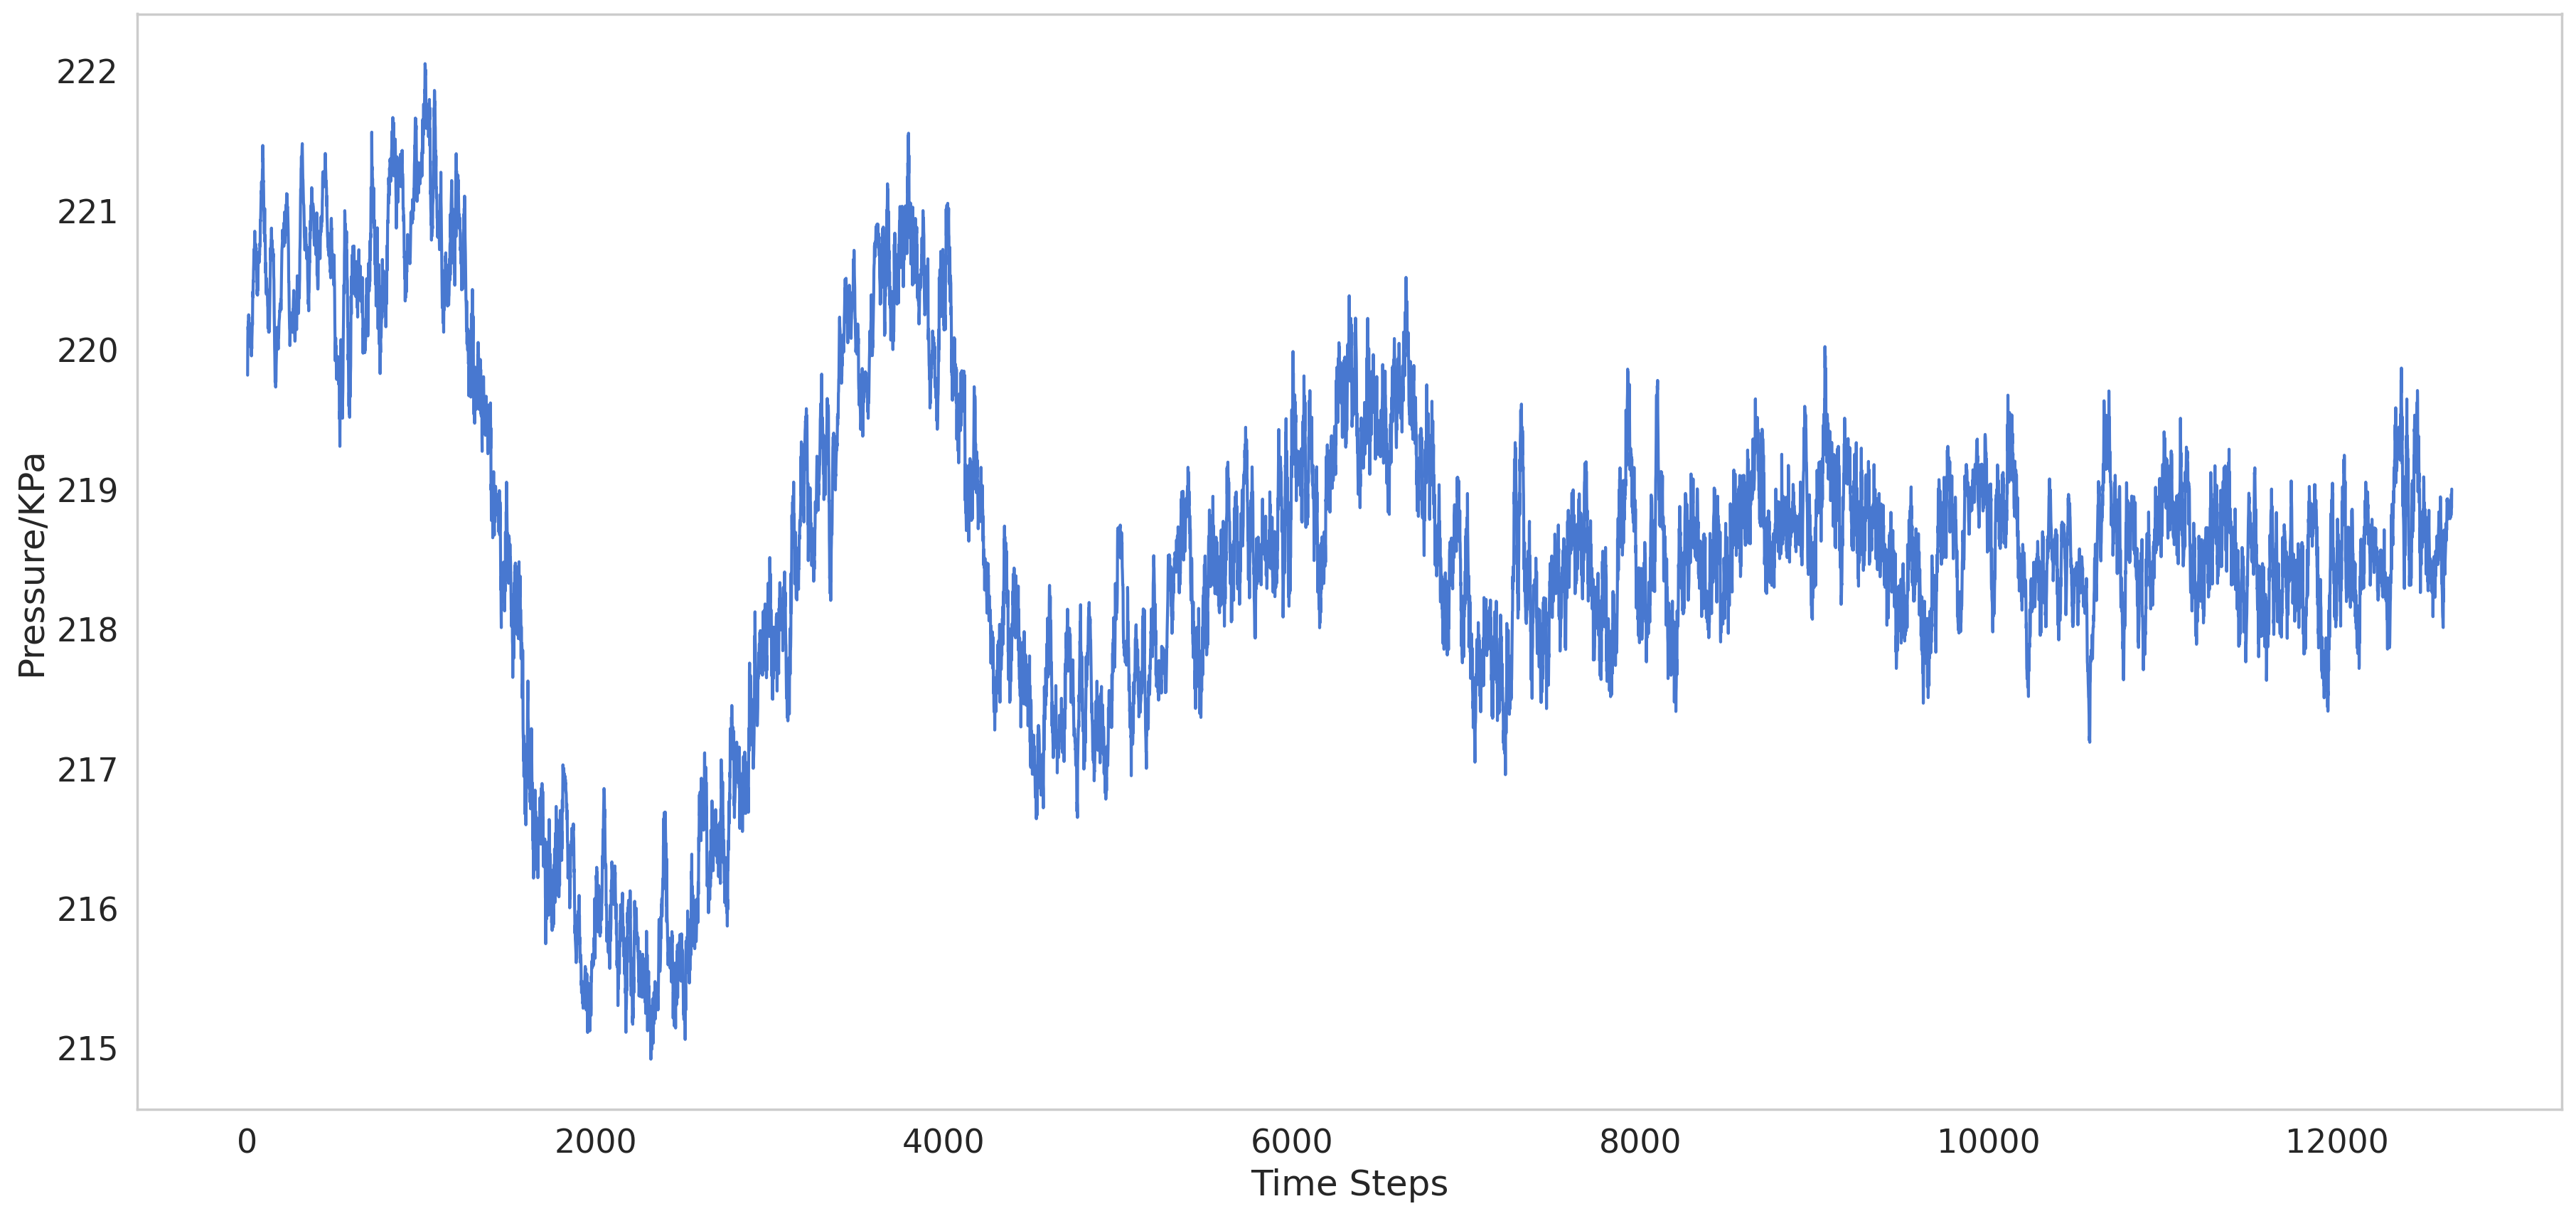

In [7]:
# prompt: 使用 DataFrame“df”: X轴是time steps，Y轴是pressure除以10后的值绘制一个图

import matplotlib.pyplot as plt

plt.plot(df["time steps"], df["pressure"]/10 )
plt.xlabel("Time Steps")
plt.ylabel("Pressure/KPa")
plt.grid(False)
plt.show()


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf


import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
#from transformers import InformerConfig, InformerModel
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [9]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
all_size = len(df)
train, test ,all= df.iloc[0:train_size], df.iloc[train_size:len(df)],df.iloc[0:len(df)],
print(train.shape, test.shape, all.shape)

(12027, 2) (633, 2) (12660, 2)


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['pressure']])
scaler = scaler.fit(all[['pressure']])

train['pressure'] = scaler.transform(train[['pressure']])
test['pressure'] = scaler.transform(test[['pressure']])
all['pressure'] = scaler.transform(all[['pressure']])

<ipython-input-10-21c5c4403de4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pressure'] = scaler.transform(train[['pressure']])
<ipython-input-10-21c5c4403de4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pressure'] = scaler.transform(test[['pressure']])


In [11]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [12]:
TIME_STEPS = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['pressure']], train.pressure, TIME_STEPS)
X_test, y_test = create_dataset(test[['pressure']], test.pressure, TIME_STEPS)
X_all, y_all = create_dataset(all[['pressure']], all.pressure, TIME_STEPS)
print(X_train.shape,X_test.shape,X_all.shape)



(12017, 10, 1) (623, 10, 1) (12650, 10, 1)


In [13]:
class ProbSparseSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(ProbSparseSelfAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        # Assert that d_model is divisible by num_heads
        assert self.d_model % self.num_heads == 0, f"d_model ({d_model}) must be divisible by num_heads ({num_heads})"

        self.depth = d_model // self.num_heads

        # Defining the dense layers for Query, Key and Value
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Fixing matrix multiplication
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        d_k = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)

        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.d_model))

        return self.dense(concat_attention)

In [14]:
class InformerEncoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, conv_filters, **kwargs):
        super(InformerEncoder, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads

        # Assert that d_model is divisible by num_heads
        assert self.d_model % self.num_heads == 0, f"d_model ({d_model}) must be divisible by num_heads ({num_heads})"

        self.self_attention = ProbSparseSelfAttention(d_model=d_model, num_heads=num_heads)

        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # This dense layer will transform the input 'x' to have the dimensionality 'd_model'
        self.dense_transform = tf.keras.layers.Dense(d_model)

        self.conv1 = tf.keras.layers.Conv1D(conv_filters, 3, padding='same')
        self.conv2 = tf.keras.layers.Conv1D(d_model, 3, padding='same')
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.dense = tf.keras.layers.Dense(d_model)

    def call(self, x):
        attn_output = self.self_attention(x, x, x)

        # Transform 'x' to have the desired dimensionality
        x_transformed = self.dense_transform(x)
        attn_output = self.norm1(attn_output + x_transformed)

        conv_output = self.conv1(attn_output)
        conv_output = tf.nn.relu(conv_output)
        conv_output = self.conv2(conv_output)

        encoded_output = self.norm2(conv_output + attn_output)

        pooled_output = self.global_avg_pooling(encoded_output)
        return self.dense(pooled_output)[:, -4:]

In [17]:
input_layer = tf.keras.layers.Input(shape=(10, 1))

# Encoder
encoder_output = InformerEncoder(d_model=360, num_heads=8, conv_filters=64)(input_layer)

# Decoder (with attention)
decoder_lstm = tf.keras.layers

In [98]:
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


def InformerModel(input_shape, d_model=64, num_heads=2, conv_filters=256, learning_rate= 1e-3):
    # Input
    input_layer = Input(shape=input_shape)

    # Encoder
    encoder_output = InformerEncoder(d_model=d_model, num_heads=num_heads, conv_filters=conv_filters)(input_layer)

    # Decoder
    repeated_output = RepeatVector(1)(encoder_output)  # Repeating encoder's output
    decoder_lstm = LSTM(312, return_sequences=True)(repeated_output)
    decoder_output = Dense(1)(decoder_lstm[:, -1, :])  # Use the last sequence output to predict the next value

    # Model
    model = Model(inputs=input_layer, outputs=decoder_output)
    # Compile the model with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')



    return model

model = InformerModel(input_shape=(look_back, 1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()



Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 10, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ informer_encoder_22                  │ (None, 4)                   │         107,712 │
│ (InformerEncoder)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_26 (RepeatVector)      │ (None, 1, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 1, 312)              │         395,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_3 (GetItem)                 │ (None, 312)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_174 (Dense)                    │ (None, 1)                   │             313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 503,641 (1.92 MB)

 Trainable params: 503,641 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [167]:
# prompt: 计算训练所用的时间

import time

start_time = time.time()

history = model.fit(
    X_train, y_train,
    epochs=11,
    batch_size=128,
    validation_split=0.1,
    shuffle=False
)

end_time = time.time()

training_time = end_time - start_time

print(f"Training time: {training_time:.4f} seconds")


Epoch 1/11
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0705 - val_loss: 0.0289
Epoch 2/11
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0661 - val_loss: 0.0287
Epoch 3/11
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0617 - val_loss: 0.0286
Epoch 4/11
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0577 - val_loss: 0.0284
Epoch 5/11
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0544 - val_loss: 0.0281
Epoch 6/11
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0519 - val_loss: 0.0279
Epoch 7/11
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0498 - val_loss: 0.0277
Epoch 8/11
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0481 - val_loss: 0.0275
Epoch 9/11
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0468 - val_loss: 0.0273
Epoch 10/11
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0458 - val_loss: 0.0272
Epoch 11/11
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0454 - val_loss: 0.0271
Training time: 14.5080 seconds


In [168]:
# prompt: 计算训练总时间花费了多少

import time

start_time = time.time()

# Train your model here

end_time = time.time()

total_time = end_time - start_time

print("Total training time:", total_time, "seconds")


Total training time: 0.00028634071350097656 seconds


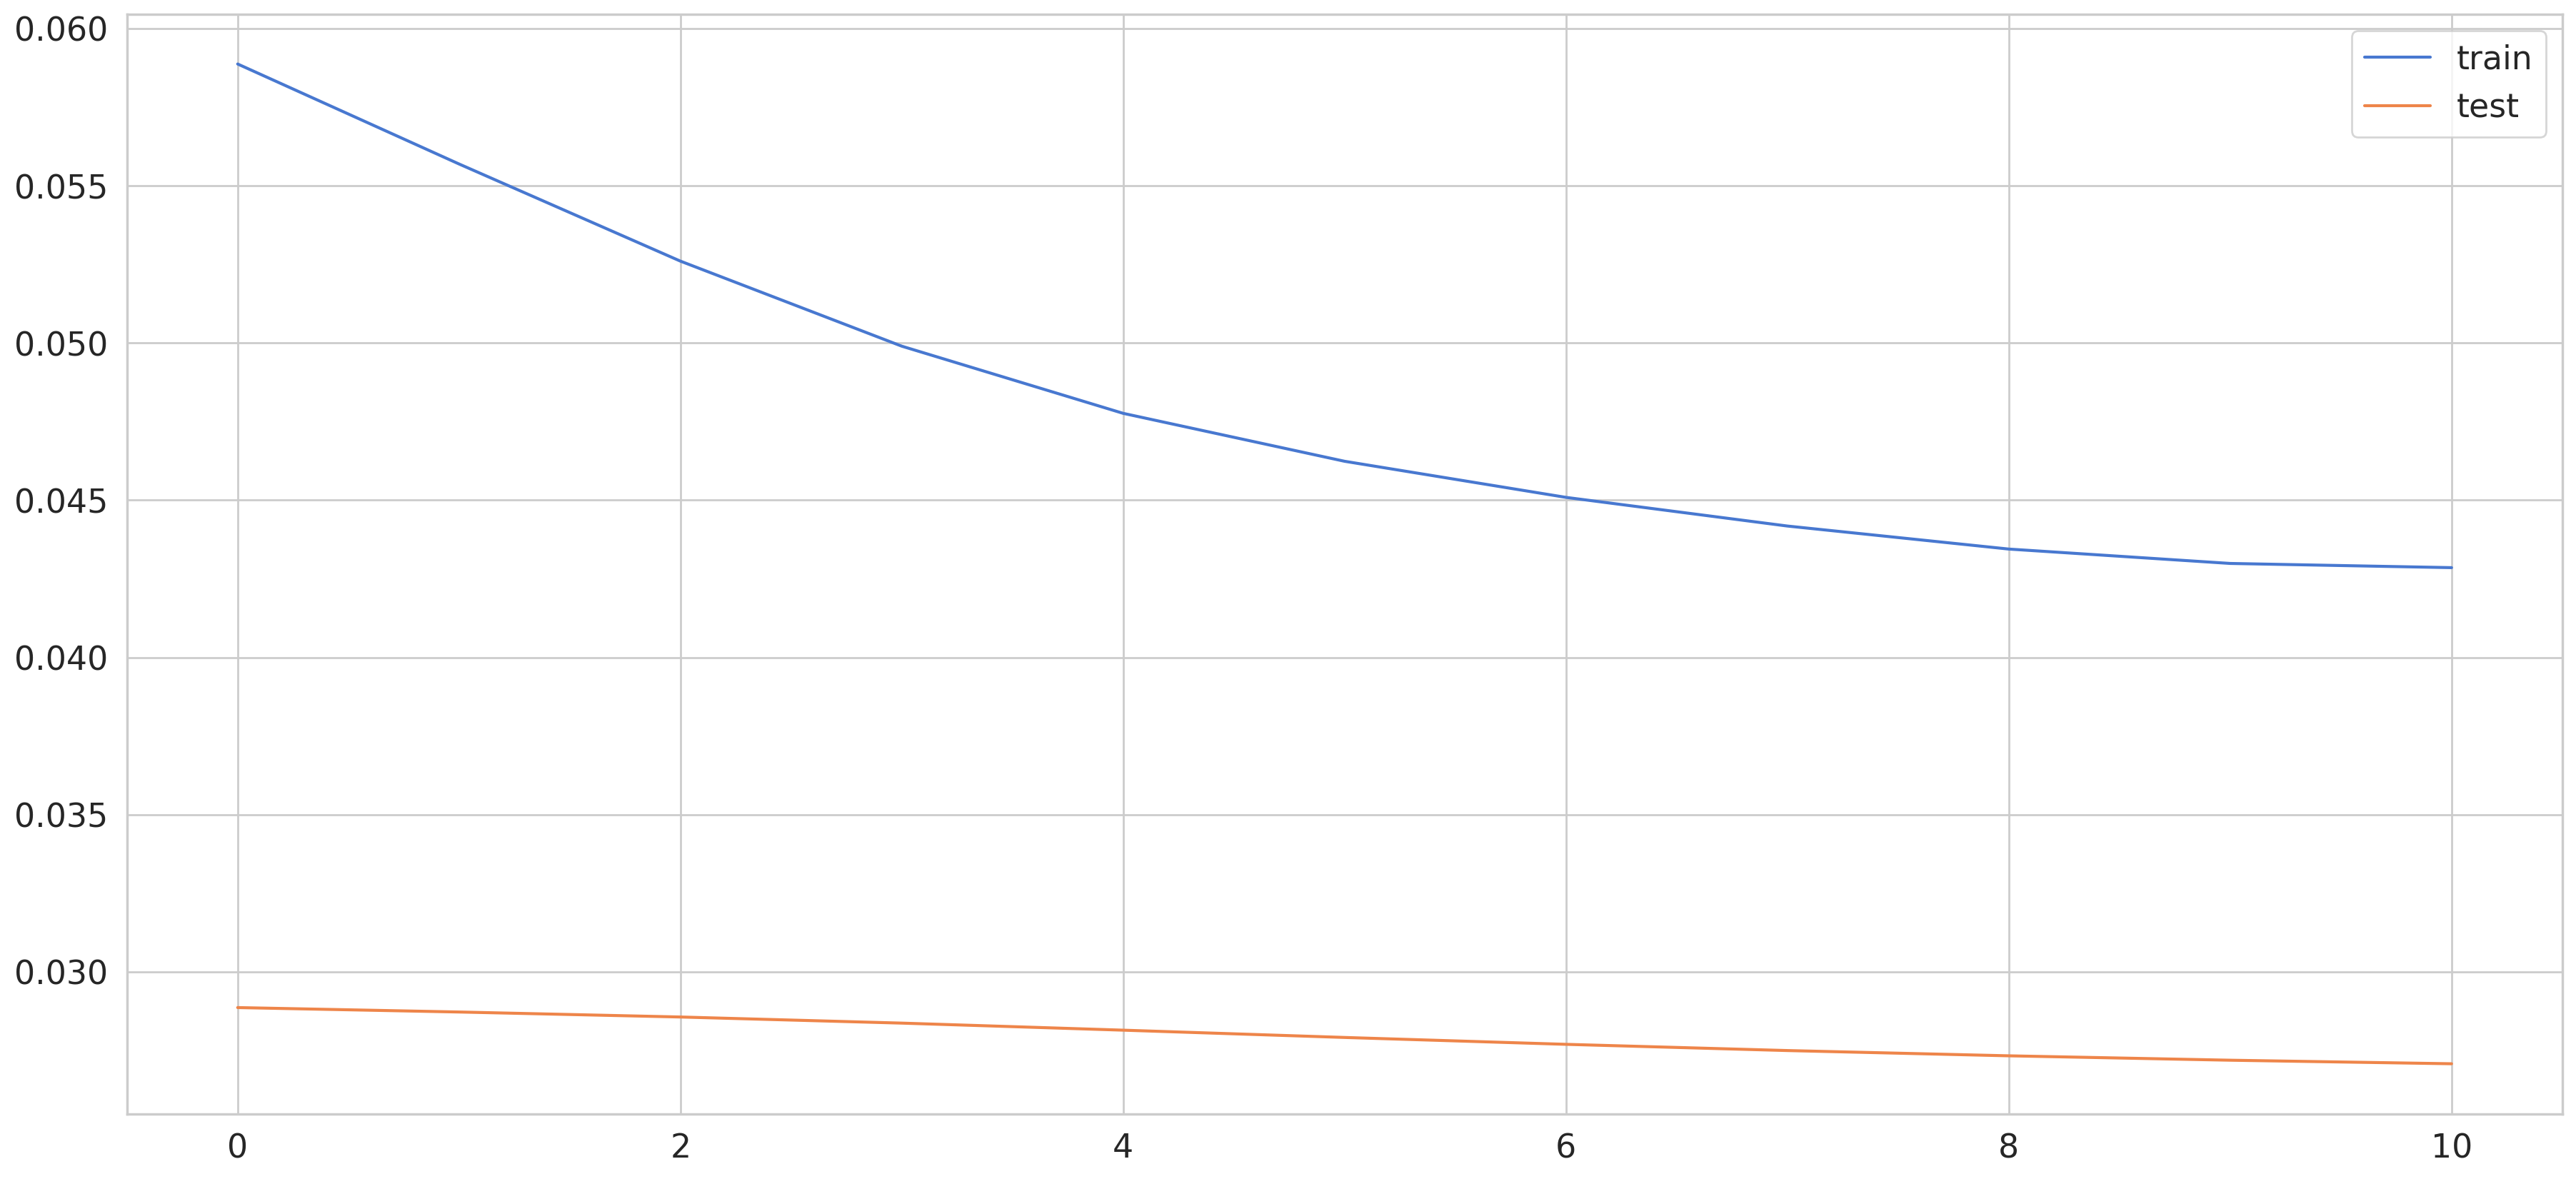

In [169]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [170]:
X_train_pred = model.predict(X_train)

X_train_reduced = np.mean(X_train, axis=1)  # 降维
train_mae_loss = np.mean(np.abs(X_train_pred - X_train_reduced), axis=1)


376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<ipython-input-171-2a82bf2958c0>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True);


预测值形状: (12017, 1)
目标值形状: (12017,)


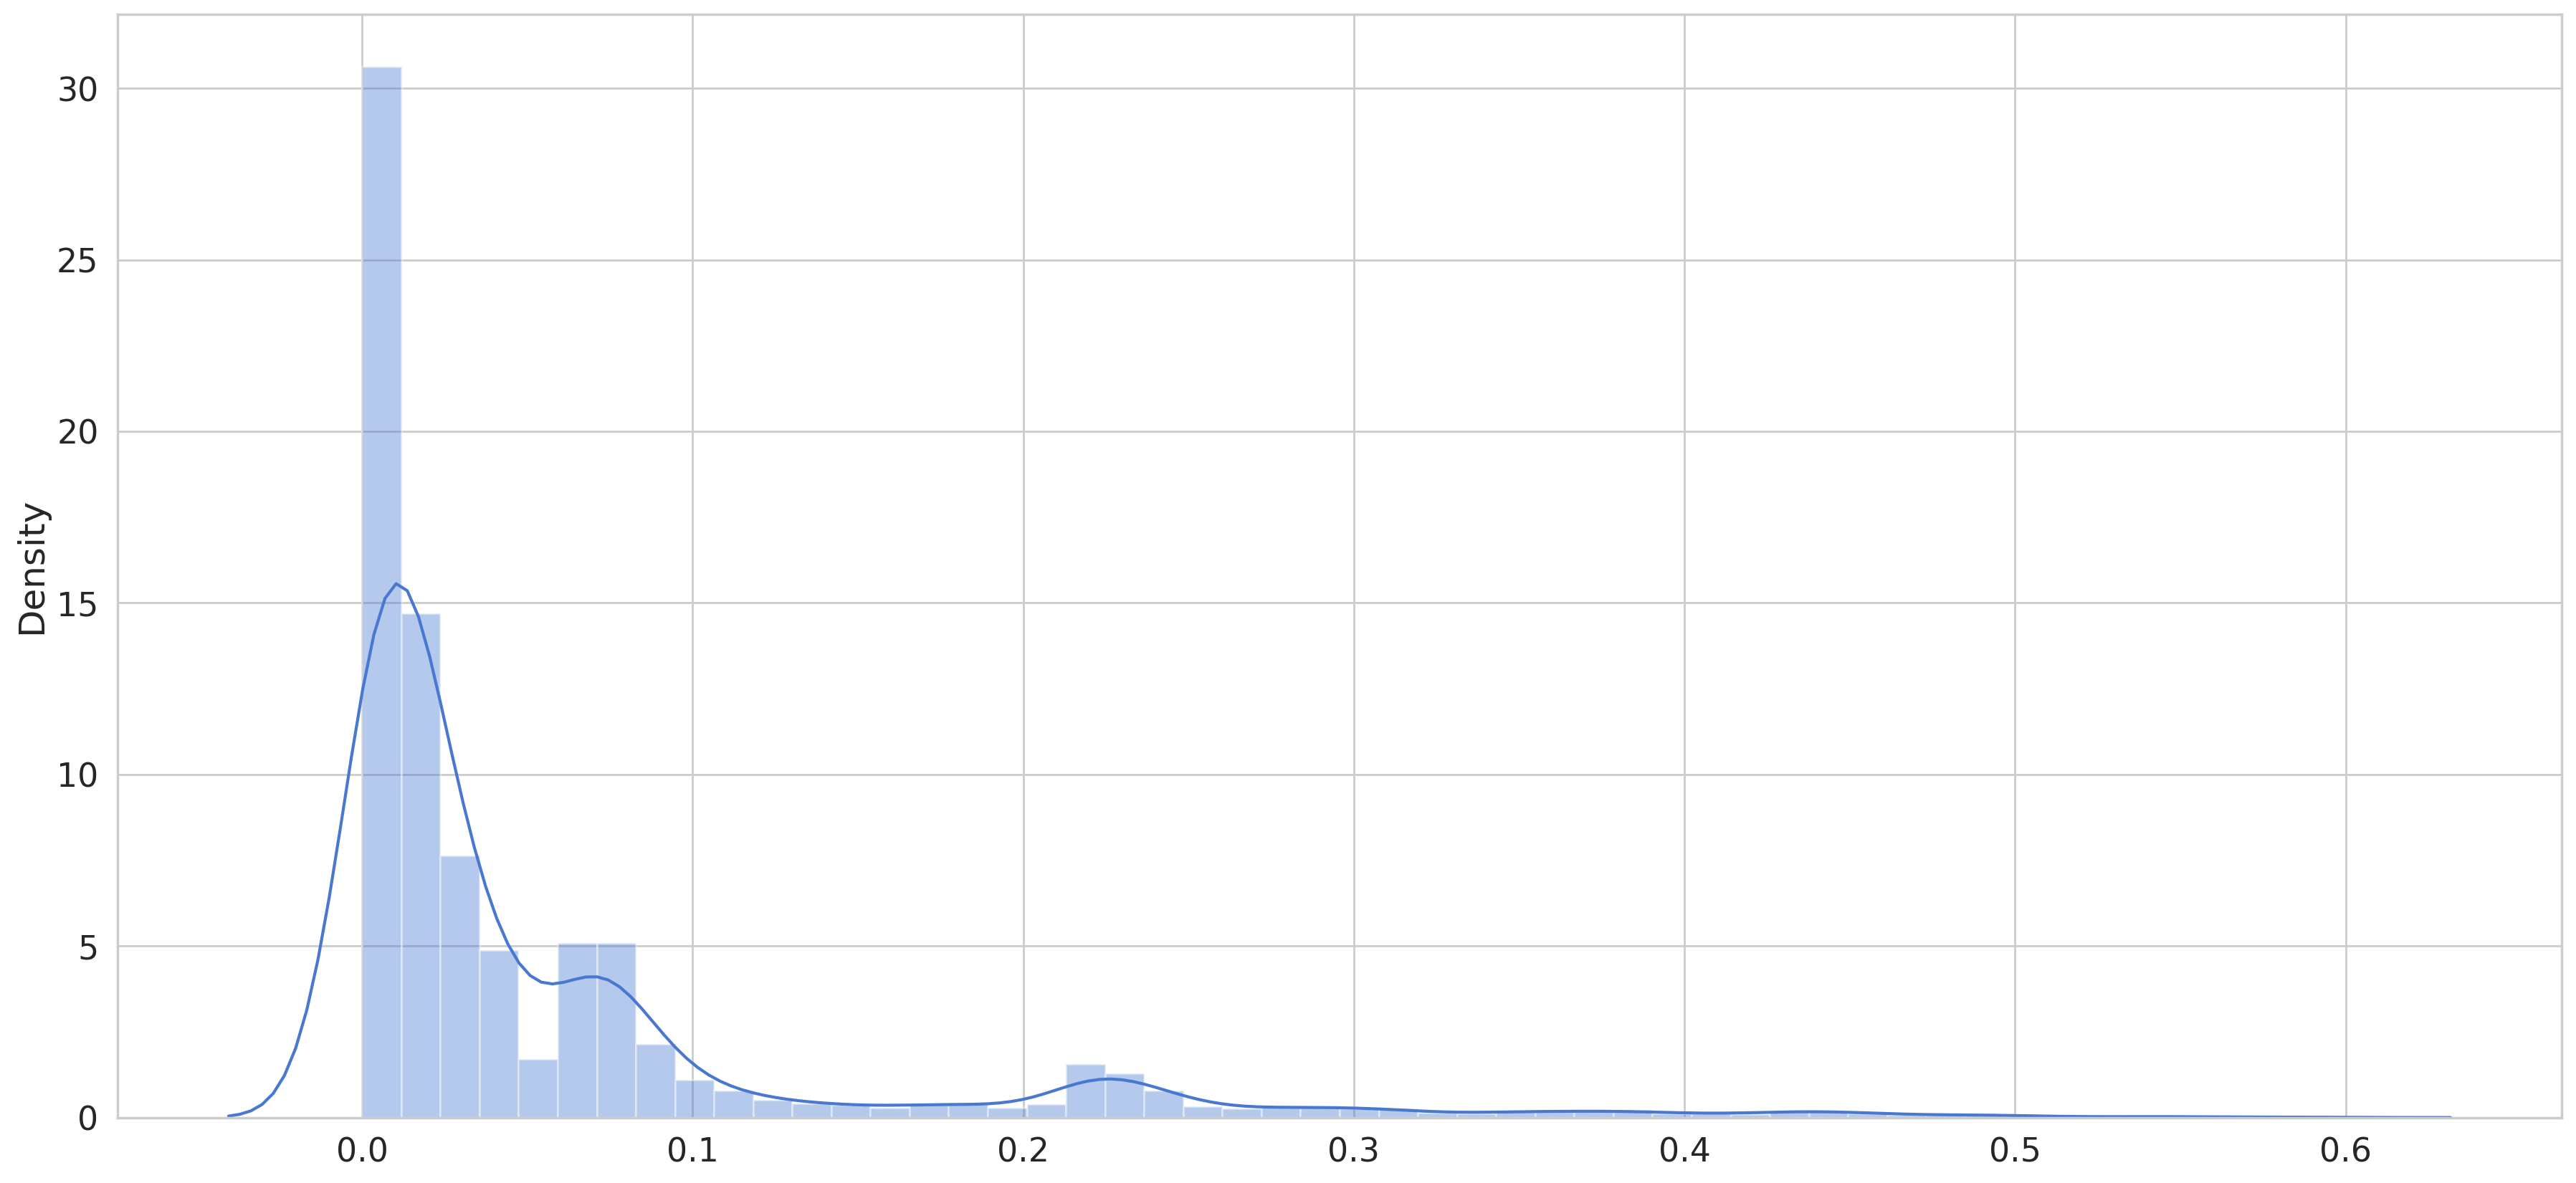

In [171]:
sns.distplot(train_mae_loss, bins=50, kde=True);
print("预测值形状:", X_train_pred.shape)  # 应为 (8475, 2)
print("目标值形状:", y_train.shape)

In [172]:
X_test_pred = model.predict(X_test)
X_test_reduced = np.mean(X_test, axis=1)  # 降维
test_mae_loss = np.mean(np.abs(X_test_pred - X_test_reduced), axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [173]:
X_all_pred = model.predict(X_all)
X_all_reduced = np.mean(X_all, axis=1)
all_mae_loss = np.mean(np.abs(X_all_pred - X_all_reduced), axis=1)

396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [174]:
THRESHOLD =0.45

all_score_df = pd.DataFrame(index=all[TIME_STEPS:].index)
all_score_df['loss'] = all_mae_loss
all_score_df['threshold'] = THRESHOLD
all_score_df['anomaly'] = all_score_df.loss > all_score_df.threshold
all_score_df['pressure'] = all[TIME_STEPS:].pressure

In [175]:
anomalies = all_score_df[all_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,pressure
1022,0.450432,0.45,True,2.707443
1023,0.473820,0.45,True,2.657170
1024,0.487856,0.45,True,2.516183
1025,0.493898,0.45,True,2.514121
1026,0.500611,0.45,True,2.451478


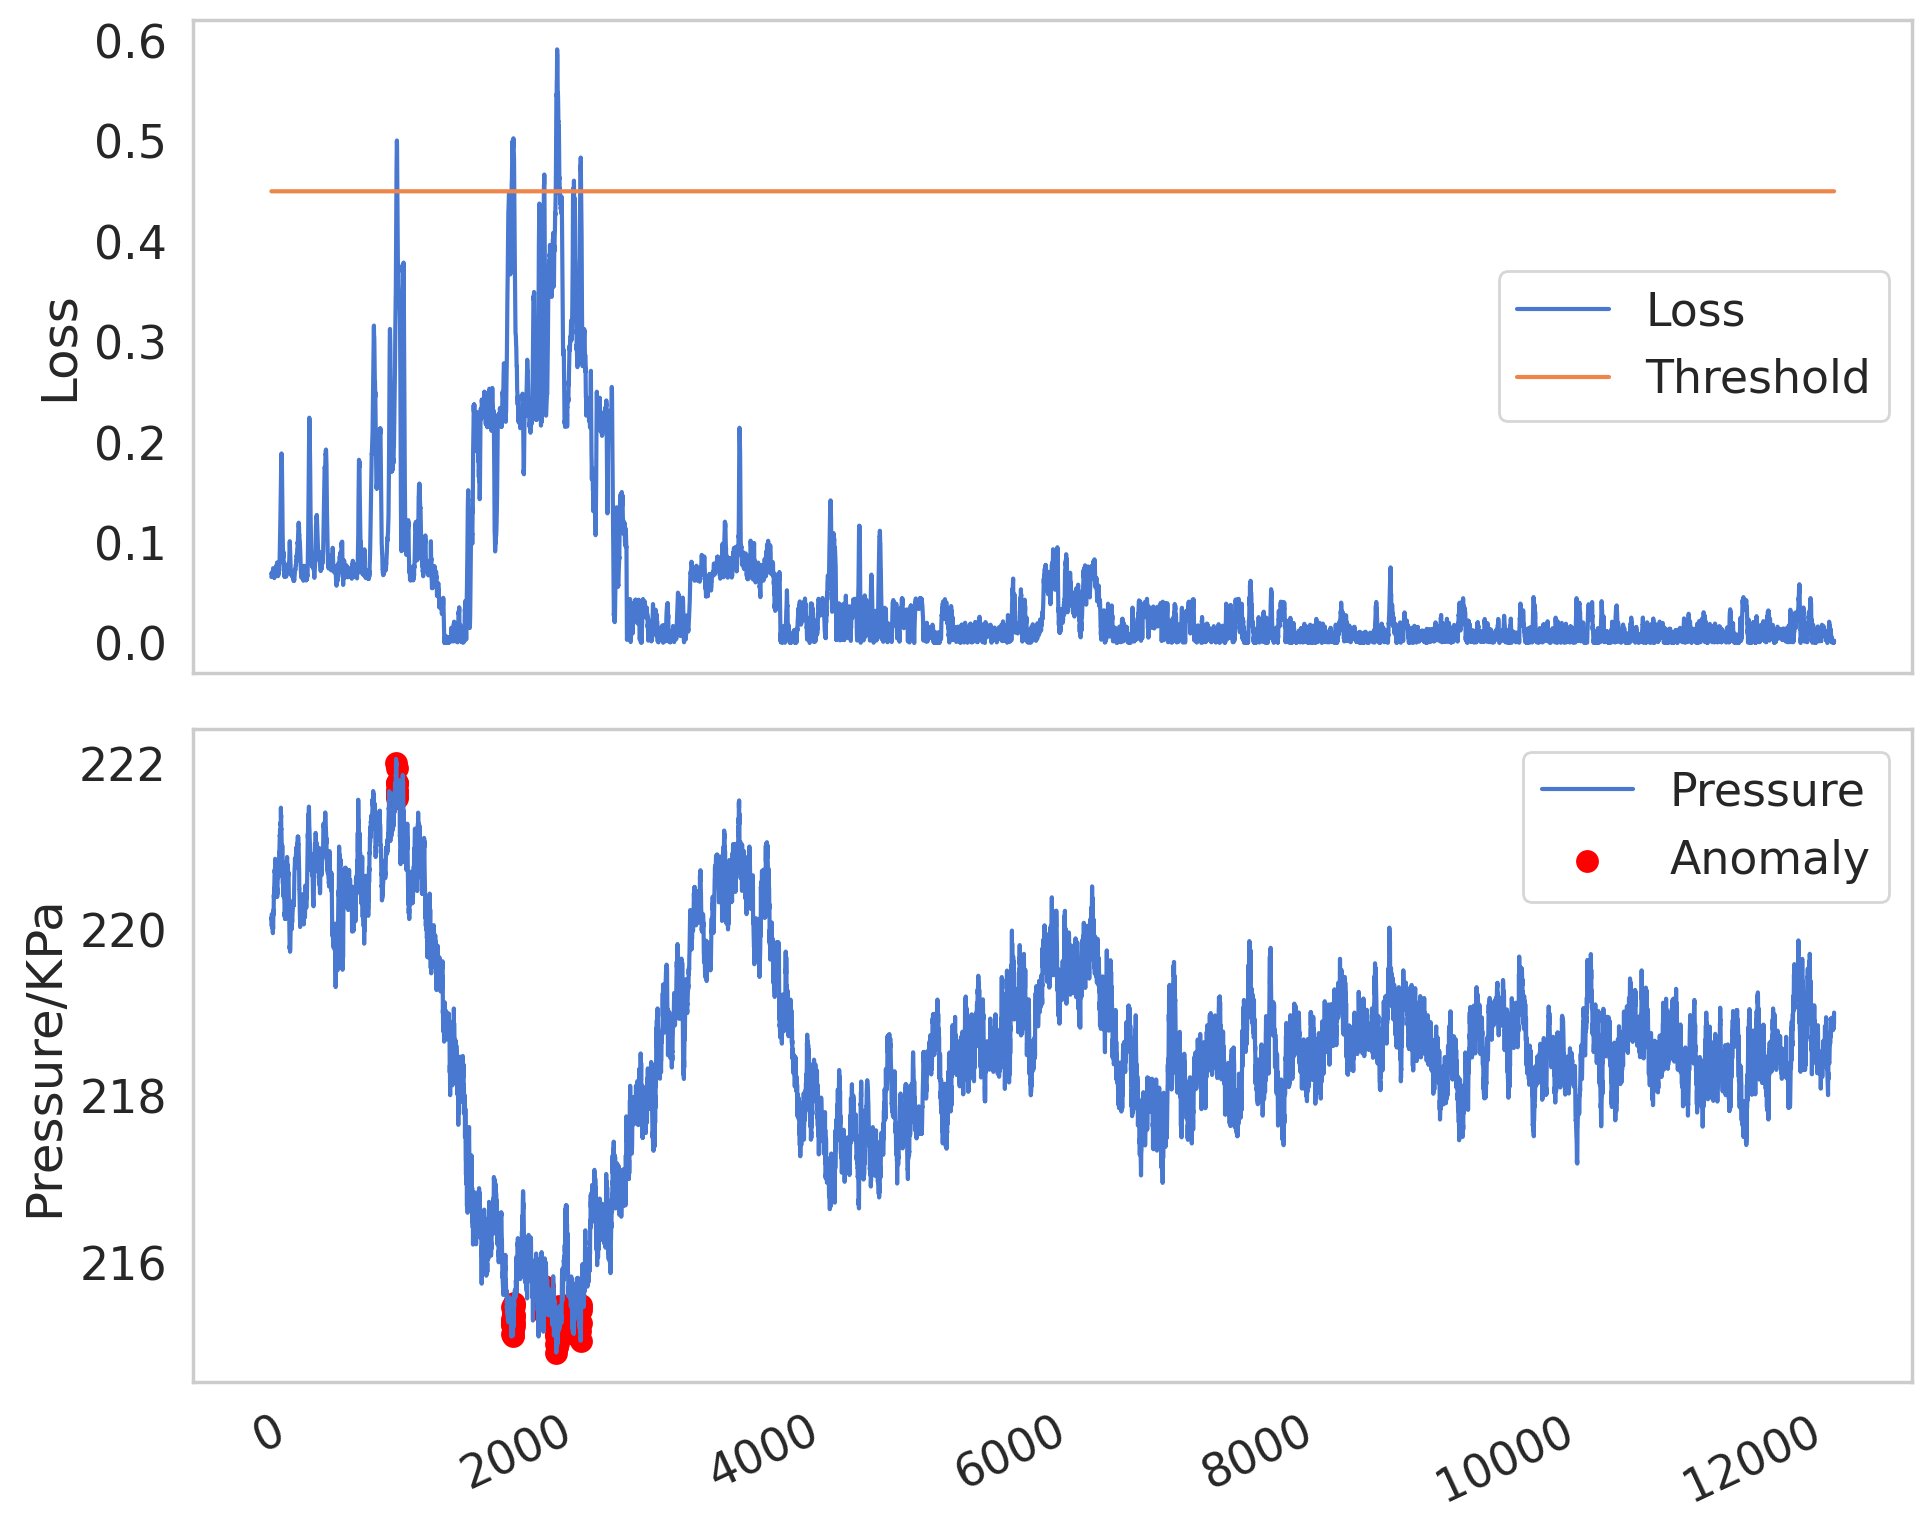

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设你已经定义了变量 'test', 'anomalies', 和 'scaler'

# 重塑数据前修改这部分
pressure_prices_all = scaler.inverse_transform(all[TIME_STEPS:].pressure.values.reshape(1, -1)).reshape(-1) / 10
pressure_prices_anomalies = scaler.inverse_transform(anomalies.pressure.values.reshape(1, -1)).reshape(-1) / 10

# 创建图形和坐标轴
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
#ax1.set_title('GRU-AE Example Demonstration of Traditional Reconstruction Error Anomaly Detection Based on Threshold', fontsize=14)

# 第一个图：压力价格与异常值, 使用 matplotlib 的 scatter 方法
ax2.plot(
  all[TIME_STEPS:].index,
  pressure_prices_all,
  label='Pressure'
)
ax2.scatter(
  anomalies.index,
  pressure_prices_anomalies,
  color='red',  # 使用红色标记异常点
  s=52,         # 设置点的大小
  label='Anomaly'
)
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels([int(x) for x in ax2.get_xticks()], rotation=25)
ax2.legend()
ax2.set_ylabel('Pressure/KPa')

# 第二个图：损失和阈值随时间变化
ax1.plot(
  all_score_df.index,
  all_score_df.loss,
  label='Loss'
)
ax1.plot(
  all_score_df.index,
  all_score_df.threshold,
  label='Threshold'
)
ax1.set_xticklabels([int(x) for x in ax1.get_xticks()], rotation=25)
ax1.legend()
ax1.set_ylabel('Loss')
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()  # 调整布局以防重叠
plt.show()


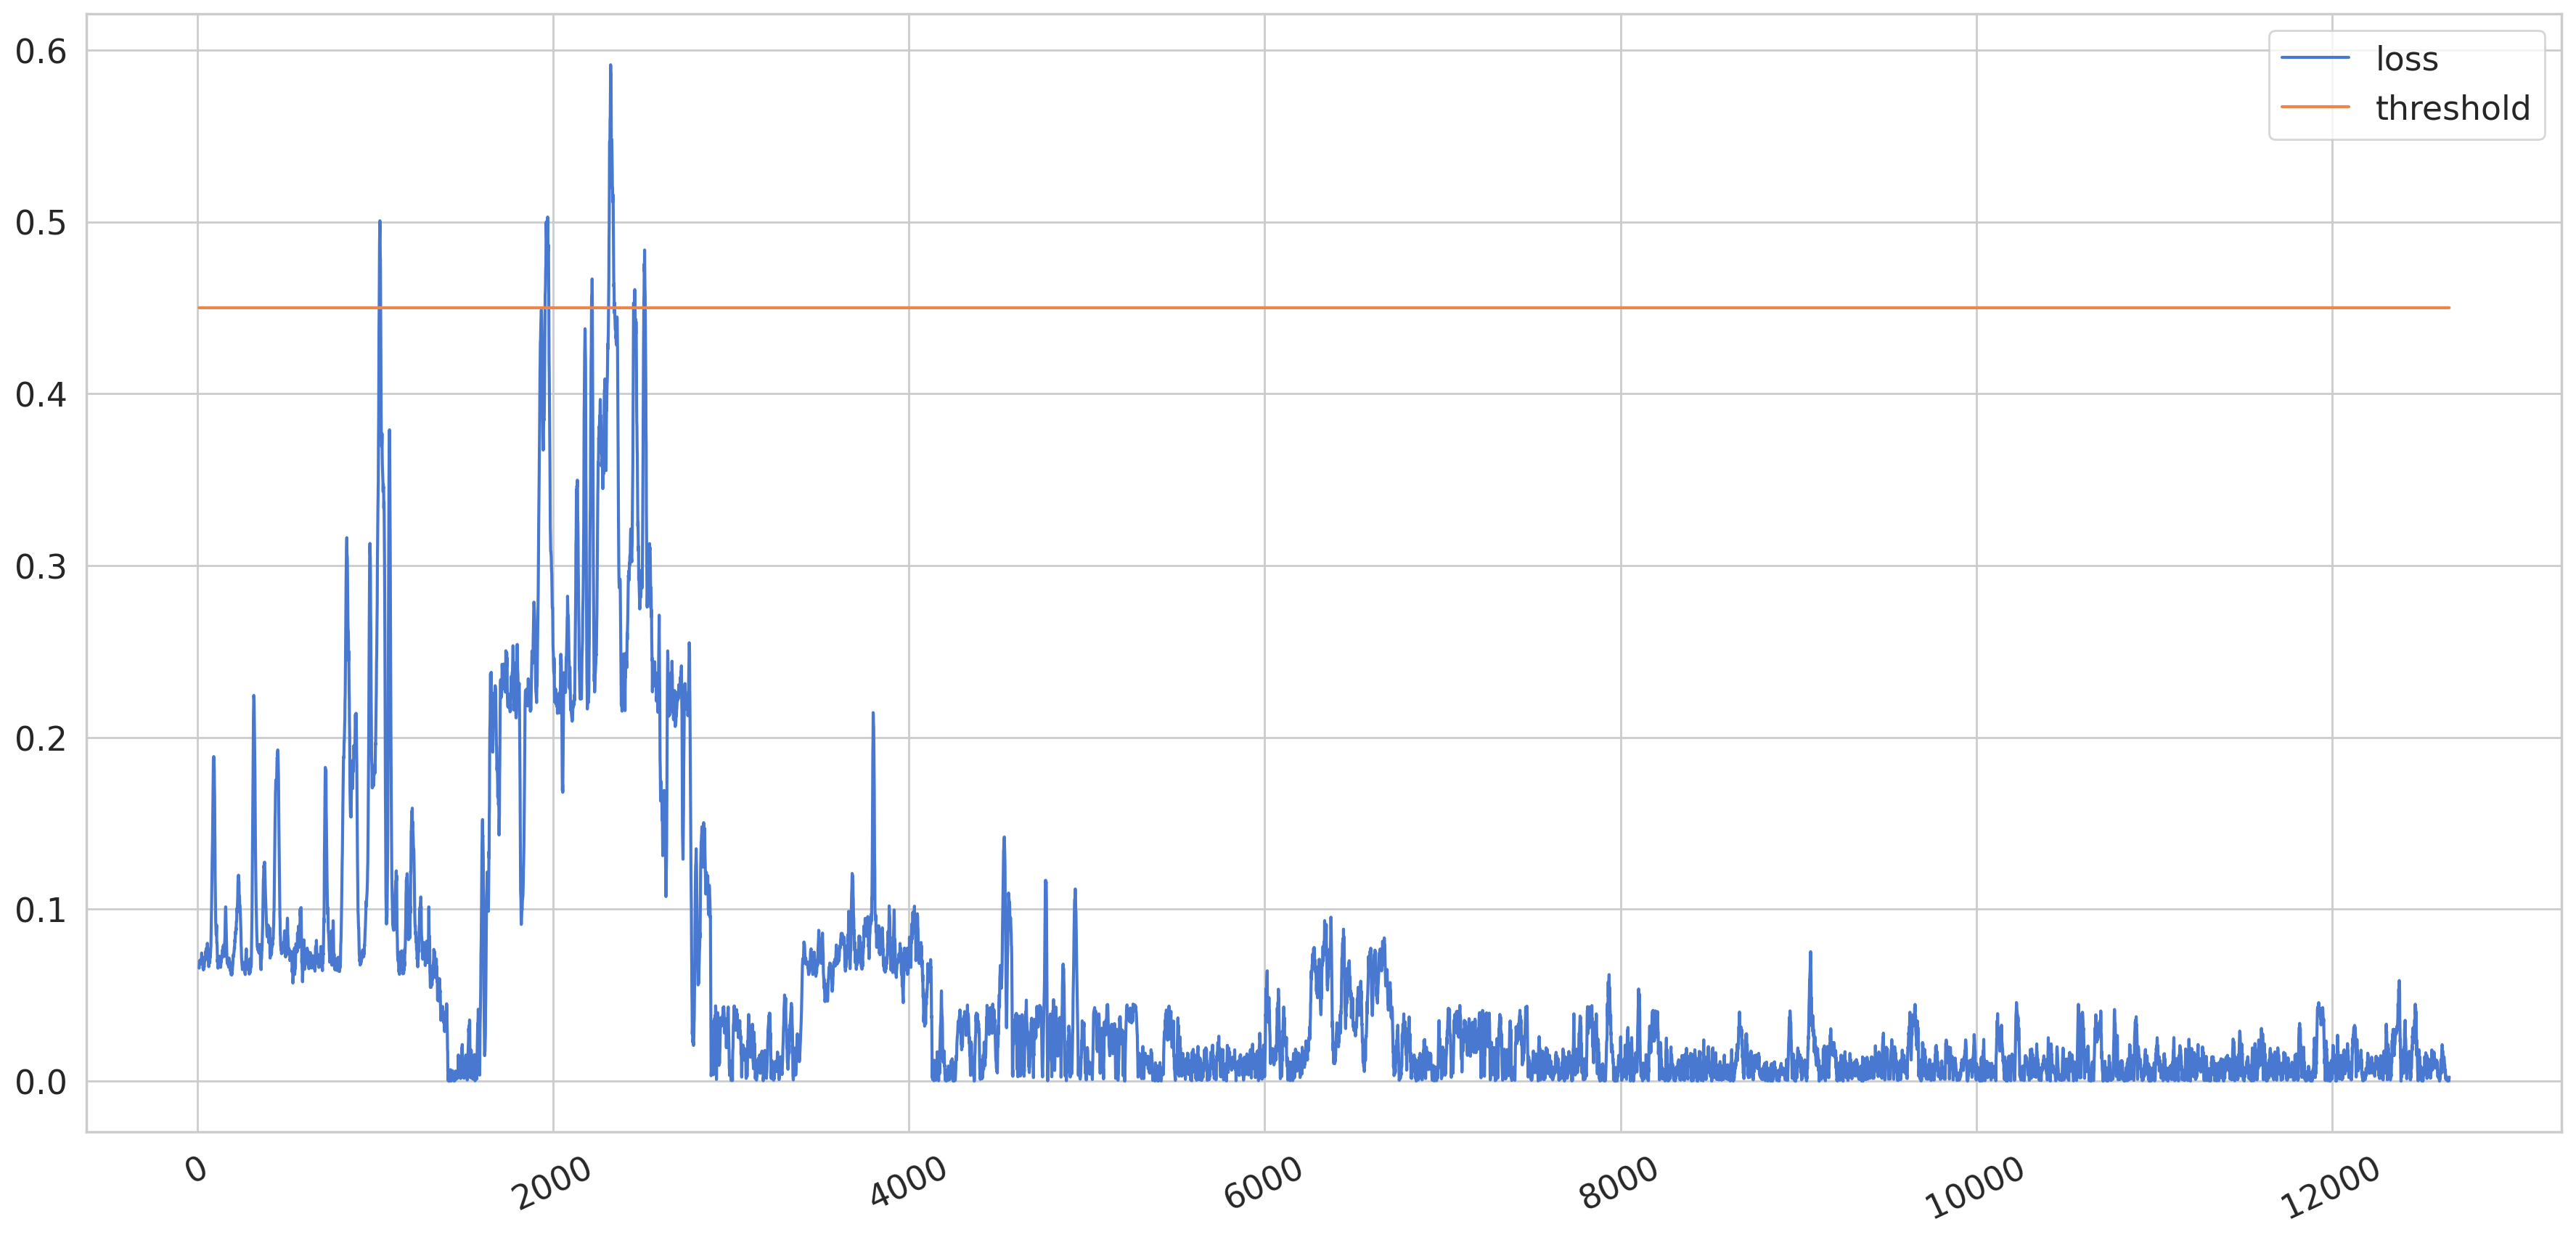

In [177]:
plt.plot(all_score_df.index, all_score_df.loss, label='loss')
plt.plot(all_score_df.index, all_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

import matplotlib.pyplot as plt
import seaborn as sns


plt.show()

In [178]:
anomalies = all_score_df[all_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,pressure
1022,0.450432,0.45,True,2.707443
1023,0.473820,0.45,True,2.657170
1024,0.487856,0.45,True,2.516183
1025,0.493898,0.45,True,2.514121
1026,0.500611,0.45,True,2.451478


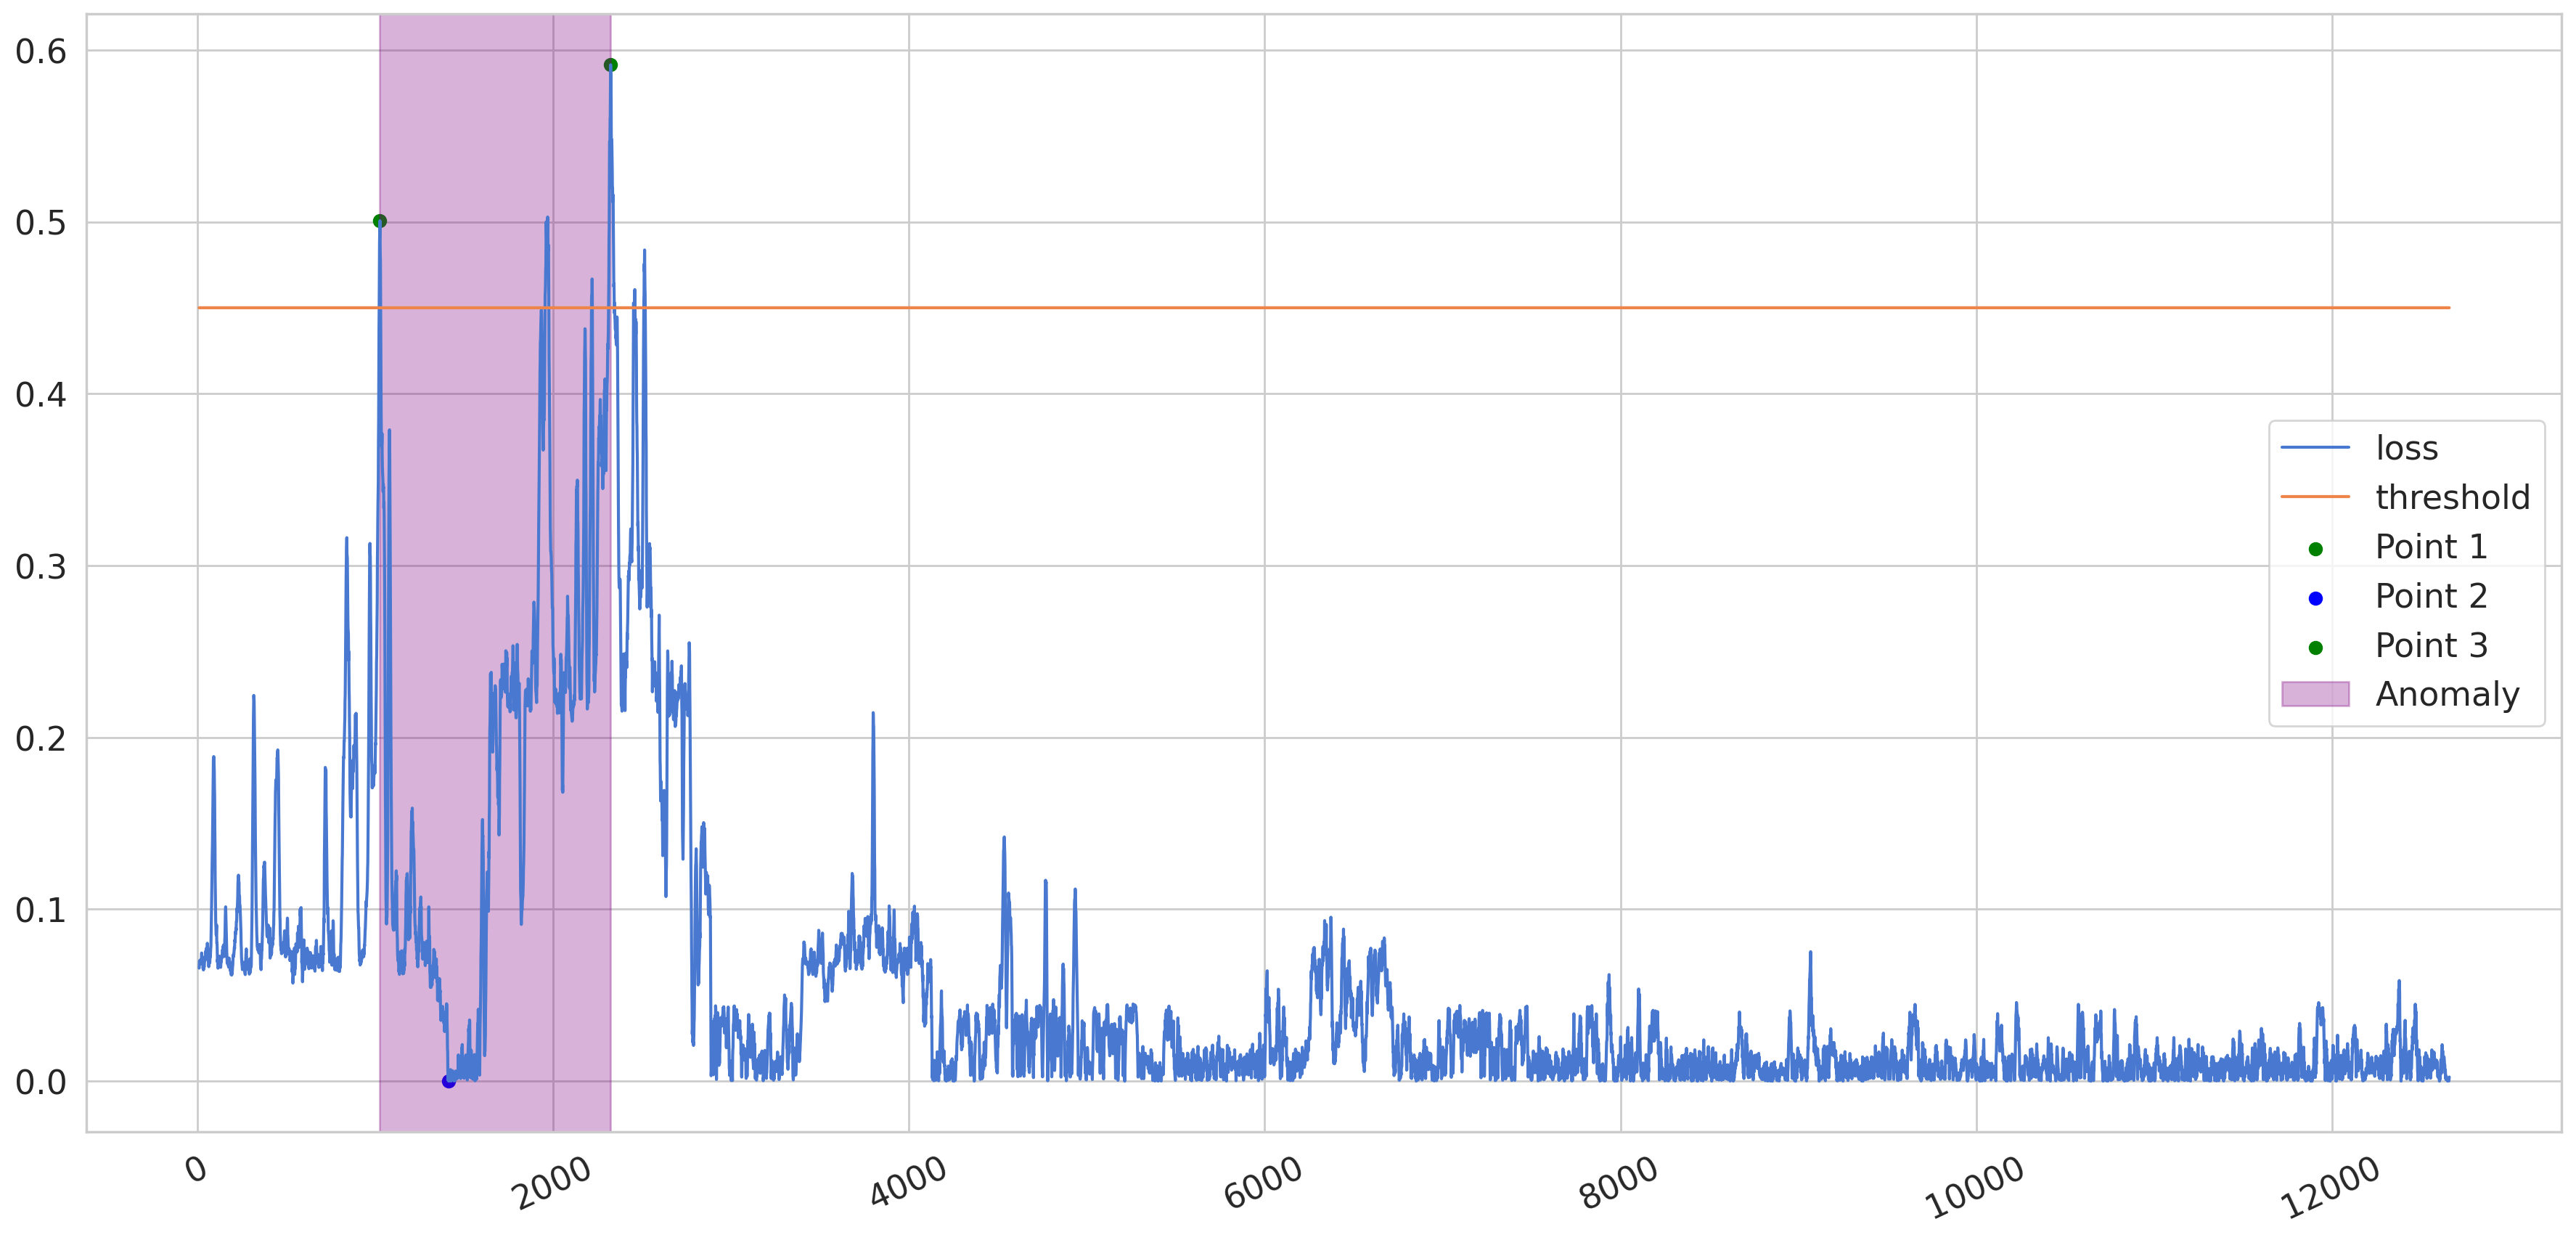

In [179]:

import matplotlib.pyplot as plt
# Find the index of the point with the maximum loss
max_loss_index = all_score_df['loss'].idxmax()

# Find the index of the point with the minimum loss before the maximum loss point
min_loss_index_before_max = all_score_df.loc[:max_loss_index]['loss'].idxmin()

# Find the index of the point with the maximum loss **before** the minimum loss point
# Search from the beginning of the DataFrame up to Point 2
max_loss_index_before_min = all_score_df.loc[:min_loss_index_before_max]['loss'].idxmax()

# Plot the points
plt.plot(all_score_df.index, all_score_df.loss, label='loss')
plt.plot(all_score_df.index, all_score_df.threshold, label='threshold')
plt.scatter(max_loss_index, all_score_df.loc[max_loss_index, 'loss'], color='green', label='Point 1')
plt.scatter(min_loss_index_before_max, all_score_df.loc[min_loss_index_before_max, 'loss'], color='blue', label='Point 2')
plt.scatter(max_loss_index_before_min, all_score_df.loc[max_loss_index_before_min, 'loss'], color='green', label='Point 3')

# Plot the points between point 1 and point 3
plt.axvspan(max_loss_index_before_min, max_loss_index, color='purple', alpha=0.3, label='Anomaly')

plt.xticks(rotation=25)
plt.legend();


In [180]:
print("Point P1: Index =", max_loss_index, ", Loss =", all_score_df.loc[max_loss_index, 'loss'])
print("Point P3: Index =", max_loss_index_before_min, ", Loss =", all_score_df.loc[max_loss_index_before_min, 'loss'])

Point P1: Index = 2323 , Loss = 0.5913707398061332
Point P3: Index = 1026 , Loss = 0.5006111532616733


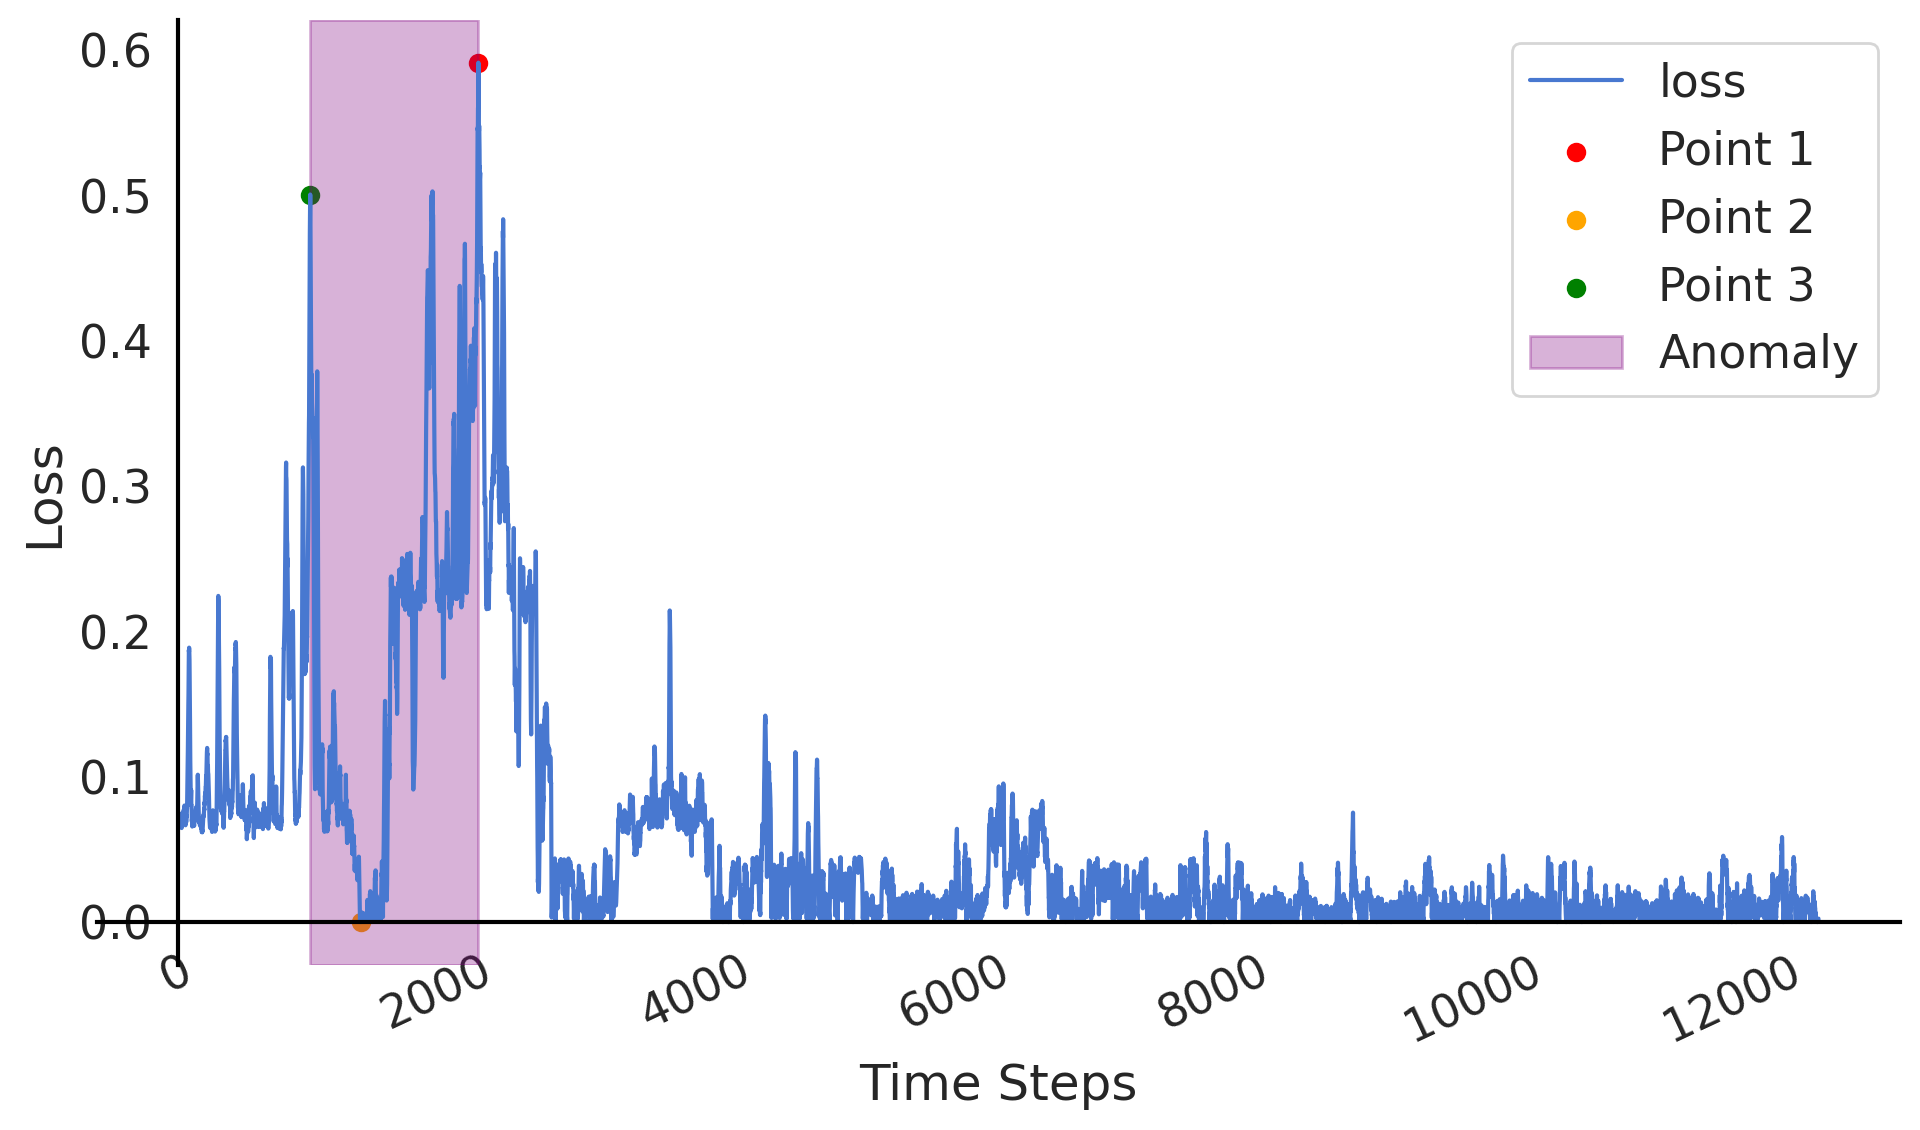

In [181]:
import matplotlib.pyplot as plt

# Create a figure and a single axis
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

# Plot loss and threshold on the axis
ax1.plot(all_score_df.index, all_score_df.loss, label='loss')
ax1.scatter(max_loss_index, all_score_df.loc[max_loss_index, 'loss'], color='red', label='Point 1')
ax1.scatter(min_loss_index_before_max, all_score_df.loc[min_loss_index_before_max, 'loss'], color='orange', label='Point 2')
ax1.scatter(max_loss_index_before_min, all_score_df.loc[max_loss_index_before_min, 'loss'], color='green', label='Point 3')
ax1.axvspan(max_loss_index_before_min, max_loss_index, color='purple', alpha=0.3, label='Anomaly')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Time Steps')
ax1.legend(loc='upper right')
ax1.grid(False)

# Add coordinate arrows for the axis
ax1.spines['top'].set_color('none')
ax1.spines['right'].set_color('none')
ax1.spines['left'].set_position(('data', all_score_df.index[0]))
ax1.spines['left'].set_color('black')
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['bottom'].set_position(('data', 0))
ax1.spines['bottom'].set_color('black')
ax1.spines['bottom'].set_linewidth(1.5)
ax1.annotate('', xy=(1.02, 0), xytext=(0, 0),
             xycoords=('axes fraction', 'data'),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='-|>', lw=1.5, color='black'))
ax1.annotate('', xy=(0, 1.02), xytext=(0, 0),
             xycoords=('data', 'axes fraction'),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='-|>', lw=1.5, color='black'))

plt.xticks(rotation=25)
plt.tight_layout()
plt.grid(False)
plt.show()


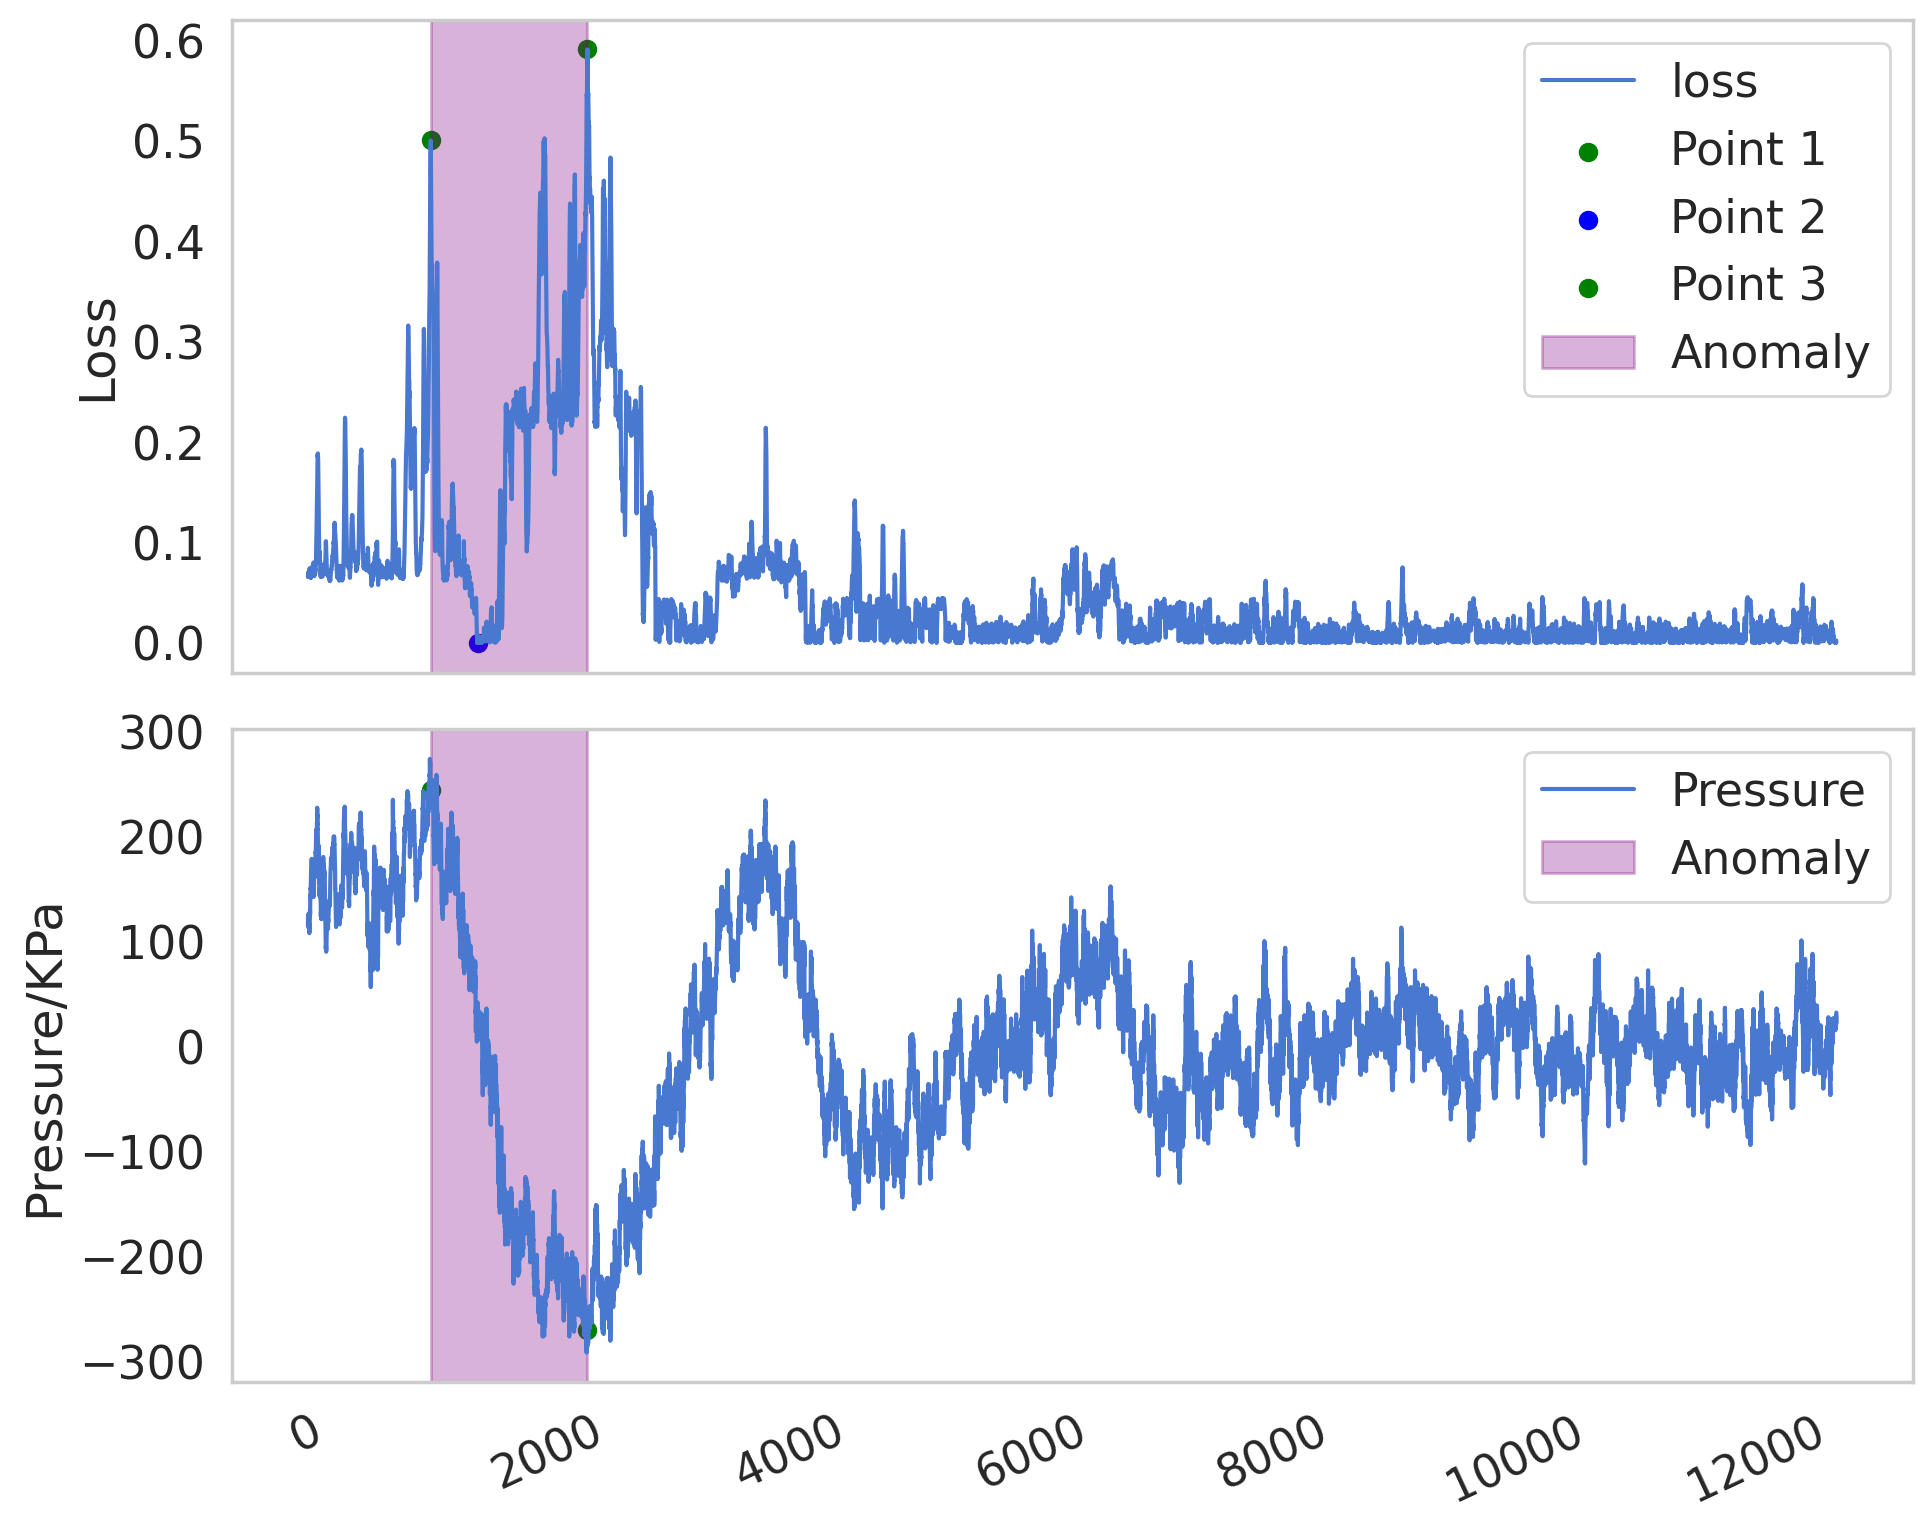

In [182]:
import matplotlib.pyplot as plt

# Assuming previous code to calculate indices remains the same

# Create a figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
#ax1.set_title('GRU-AE Example Demonstration', fontsize=14)
# Plot loss and threshold on the first axis
ax1.plot(all_score_df.index, all_score_df.loss, label='loss')
ax1.scatter(max_loss_index, all_score_df.loc[max_loss_index, 'loss'], color='green', label='Point 1')
ax1.scatter(min_loss_index_before_max, all_score_df.loc[min_loss_index_before_max, 'loss'], color='blue', label='Point 2')
ax1.scatter(max_loss_index_before_min, all_score_df.loc[max_loss_index_before_min, 'loss'], color='green', label='Point 3')
ax1.axvspan(max_loss_index_before_min, max_loss_index, color='purple', alpha=0.3, label='Anomaly')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')
ax1.grid(False)

# Plot pressure on the second axis with adjusted Y axis
ax2.plot(all_score_df.index, all_score_df.pressure * 100, label='Pressure')
ax2.scatter(max_loss_index, all_score_df.loc[max_loss_index, 'pressure'] * 100, color='green')
ax2.scatter(max_loss_index_before_min, all_score_df.loc[max_loss_index_before_min, 'pressure'] * 100, color='green')
ax2.axvspan(max_loss_index_before_min, max_loss_index, color='purple', alpha=0.3, label='Anomaly')
ax2.set_ylabel('Pressure/KPa')
ax2.legend(loc='upper right')

plt.xticks(rotation=25)
plt.tight_layout()
plt.grid(False)
plt.show()

In [183]:
print("Point P1: Index =", max_loss_index, ", Loss =", all_score_df.loc[max_loss_index, 'loss'])
print("Point P3: Index =", max_loss_index_before_min, ", Loss =", all_score_df.loc[max_loss_index_before_min, 'loss'])

Point P1: Index = 2323 , Loss = 0.5913707398061332
Point P3: Index = 1026 , Loss = 0.5006111532616733
